In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
import os
from PIL import Image
if torch.cuda.is_available():
    print(torch.cuda.device_count())
device = torch.device("cuda:0")
print(device)

3
cuda:0


In [2]:
import glob
import re
import json
from pathlib import Path
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
histwindow = 1 #  過去何分のデータを食わせるか
batchsize = 200
testsize = 10
epochs = 300
allsensors = (
    'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
    'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10',
    'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
    'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21')
fpath = '/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50'

In [4]:
alldata = {}
def sensdata(name):
    jso = open("/proj/NARO/sonoda/orchid/sonoda/{}/all.json".format(name))
    jsl = json.load(jso)
    alldata[name] = jsl
for sname in allsensors:
    sensdata(sname)

In [5]:
files = glob.glob(fpath+'/*.jpg')
sdata = []
fdata = []
tdata = []
for file in files:
    reres = re.findall('.*/data_(20\d\d)(\d\d)(\d\d)_(\d\d)(\d\d)(\d\d).jpg', file)
    (year, month, day, hour, minute, sec) = reres[0]
    dt_date = datetime(int(year), int(month), int(day), int(hour), int(minute), int(sec))
    dt_epoch = int((dt_date.timestamp()+30)/60)*60
    dt_adj = datetime.fromtimestamp(dt_epoch)
    dt_prev = dt_adj
    time_adj = dt_adj.strftime('%Y-%m-%d-%H-%M')
    time_prev = time_adj
    sensd = []
    histerr = 0
    for hist in range(0, histwindow):
        for sname in allsensors:
            if alldata[sname].get(time_prev):
                sensd.append(alldata[sname][time_prev]['Temperature'])
            else:
                histerr = 1
                break
        if histerr:
            break
        dt_prev = dt_prev - timedelta(minutes=1)
        time_prev = dt_prev.strftime('%Y-%m-%d-%H-%M')
    if not histerr:
        sdata.append(sensd)
        tdata.append(time_adj)
        fdata.append(file)

Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211230_045455.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220101_201617.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_000241.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220112_193520.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_190227.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220113_062810.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220114_100430.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_203439.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_122725.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220109_084430.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_104203.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220114_093758.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220109_191632.jpg
Error:/auto/

Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220109_171423.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220113_162245.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220115_062524.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211230_060837.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220110_184937.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220111_134041.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_174843.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220102_101917.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220110_222724.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220109_055947.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220114_172513.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220115_214913.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_164300.jpg
Error:/auto/

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.data_num = len(tdata)
    def __len__(self):
        return self.data_num
    def __getitem__(self, idx):
        image = Image.open(fdata[idx])
#        if self.transform:
#            out_data = self.transform(image)
        out_data = np.array(image).reshape(16*18).astype(np.int32) 
        out_data = out_data*50/255
        return torch.Tensor(sdata[idx]), torch.Tensor(out_data) 
data_set = MyDataset()

In [7]:
def heatmapshow(data):
    im = Image.fromarray(data[0].numpy().reshape([16,18]).copy()*255/50)
    fig, ax = plt.subplots()
    ax.imshow(im, cmap="gray")
    plt.show()

In [13]:
train_size = len(data_set)*0.8
train_size

964.8000000000001

In [14]:
from torch.utils.data.dataset import Subset
def split_dataset(data_set, split_at, order=None):#order = Noneは，呼び出し時に指定されなかったらデフォルトで　Noneを使ってねといういう意味
    from torch.utils.data.dataset import Subset
    n_examples = len(data_set)
    if split_at < 0:
        raise ValueError('split_at must be non-negative')
    if split_at > n_examples:
        raise ValueError('split_at exceeds the dataset size')
    if order is not None:
        subset1_indices = order[0:split_at]
        subset2_indices = order[split_at:n_examples]
    else:
        subset1_indices = list(range(0,split_at))
        subset2_indices = list(range(split_at,n_examples))

    subset1 = Subset(data_set, subset1_indices)
    subset2 = Subset(data_set, subset2_indices)
    return subset1, subset2

def split_dataset_random(data_set, first_size, seed=0):
    order = np.random.RandomState(seed).permutation(len(data_set))
    return split_dataset(data_set, int(first_size), order)

In [16]:
test_dataset, data_set = split_dataset_random(data_set, testsize, seed=0)
train_dataset, val_dataset = split_dataset_random(data_set, train_size, seed=0)

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
train_loader = DataLoader(dataset=data_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=data_set, batch_size=batchsize, shuffle=False)

10
1196


In [17]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.fc1 = nn.Linear(xsize, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 13*15)
        self.conv = nn.Sequential(
            torch.nn.ConvTranspose2d(1, 1, kernel_size=(4, 4),  stride=(1, 1)),
            torch.nn.ReLU(),
        )
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(x.size(0), 1, 13, 15)
        x = self.conv(x)
        return x
model = NET().to(device)
model

NET(
  (fc1): Linear(in_features=21, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=195, bias=True)
  (conv): Sequential(
    (0): ConvTranspose2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
)

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    
    model.train()
    train_running_loss = 0
    for batch_idx, (x, c) in enumerate(train_loader):
        x = x.to(device)
        c = c.to(device)
        optimizer.zero_grad()
        y = model(x)

        c = c.view(x.size(0), 1, 16, 18)
        train_loss = criterion(y, c)
        train_running_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
    train_loss_list.append(train_loss)
    train_loss = train_running_loss / len(train_loader) 
    
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for batch_idx, (x, c) in enumerate(val_loader):
            x = x.to(device)
            c = c.to(device)
            c = c.view(x.size(0), 1, 16, 18)
            y = model(x)
            val_loss = criterion(y, c)
            val_running_loss += val_loss.item()
        val_loss_list.append(val_loss)

    if epoch == 0:
        best_epoch = epoch
        torch.save(model.state_dict(), 'model.pth')
        best_valid_loss = val_running_loss
    else:
        if best_valid_loss > val_running_loss:
            torch.save(model.state_dict(), f"model{epoch}.pth")
            best_valid_loss = val_running_loss
            best_epoch = epoch

    val_loss = val_running_loss / len(val_loader)  
    print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, train_loss, val_loss))
    
print('best_epoch', best_epoch)

epoch 0, loss: 476.3538 val_loss: 431.8766
epoch 1, loss: 379.5871 val_loss: 327.6968
epoch 2, loss: 322.2427 val_loss: 294.9143
epoch 3, loss: 289.9325 val_loss: 286.1466
epoch 4, loss: 278.8995 val_loss: 270.8324
epoch 5, loss: 266.2802 val_loss: 257.6602
epoch 6, loss: 252.7886 val_loss: 245.8739
epoch 7, loss: 241.6762 val_loss: 237.4977
epoch 8, loss: 234.8205 val_loss: 231.4675
epoch 9, loss: 229.3677 val_loss: 226.6536
epoch 10, loss: 224.1035 val_loss: 220.1028
epoch 11, loss: 216.4863 val_loss: 211.9026
epoch 12, loss: 209.4847 val_loss: 206.1336
epoch 13, loss: 203.9903 val_loss: 199.7456
epoch 14, loss: 196.4104 val_loss: 192.2837
epoch 15, loss: 189.7793 val_loss: 185.6482
epoch 16, loss: 181.6799 val_loss: 177.0997
epoch 17, loss: 176.3082 val_loss: 175.2259
epoch 18, loss: 173.4000 val_loss: 170.7482
epoch 19, loss: 169.4630 val_loss: 167.4542
epoch 20, loss: 164.5832 val_loss: 160.8407
epoch 21, loss: 159.7415 val_loss: 158.4329
epoch 22, loss: 156.7352 val_loss: 153.542

epoch 198, loss: 1.0281 val_loss: 0.9853
epoch 199, loss: 1.0356 val_loss: 1.4240
epoch 200, loss: 1.0837 val_loss: 0.9476
epoch 201, loss: 0.9992 val_loss: 0.9576
epoch 202, loss: 1.1201 val_loss: 0.9236
epoch 203, loss: 0.9445 val_loss: 0.9630
epoch 204, loss: 0.9557 val_loss: 1.0843
epoch 205, loss: 1.0080 val_loss: 1.0916
epoch 206, loss: 1.1282 val_loss: 0.9760
epoch 207, loss: 1.0351 val_loss: 1.1040
epoch 208, loss: 1.0582 val_loss: 0.9266
epoch 209, loss: 0.9217 val_loss: 0.9080
epoch 210, loss: 0.9338 val_loss: 0.9420
epoch 211, loss: 0.9744 val_loss: 0.9471
epoch 212, loss: 0.9636 val_loss: 0.9293
epoch 213, loss: 0.9816 val_loss: 0.9013
epoch 214, loss: 1.0248 val_loss: 0.9464
epoch 215, loss: 1.0885 val_loss: 0.9141
epoch 216, loss: 1.0477 val_loss: 0.8967
epoch 217, loss: 0.9020 val_loss: 0.8937
epoch 218, loss: 0.8973 val_loss: 0.9200
epoch 219, loss: 0.9085 val_loss: 0.8999
epoch 220, loss: 0.9125 val_loss: 0.9537
epoch 221, loss: 1.1137 val_loss: 1.4822
epoch 222, loss:

epoch 398, loss: 0.9973 val_loss: 0.8778
epoch 399, loss: 0.8645 val_loss: 0.8230
epoch 400, loss: 0.7867 val_loss: 0.7746
epoch 401, loss: 0.7636 val_loss: 0.7850
epoch 402, loss: 0.8759 val_loss: 0.7665
epoch 403, loss: 0.7973 val_loss: 0.7632
epoch 404, loss: 0.7745 val_loss: 0.7979
epoch 405, loss: 0.7770 val_loss: 0.7480
epoch 406, loss: 0.8245 val_loss: 0.7440
epoch 407, loss: 0.8580 val_loss: 0.7859
epoch 408, loss: 0.9886 val_loss: 0.9860
epoch 409, loss: 0.8810 val_loss: 0.8783
epoch 410, loss: 0.8289 val_loss: 0.8556
epoch 411, loss: 0.9520 val_loss: 1.0221
epoch 412, loss: 0.9217 val_loss: 0.9523
epoch 413, loss: 0.8179 val_loss: 0.7414
epoch 414, loss: 0.7880 val_loss: 0.7428
epoch 415, loss: 0.7649 val_loss: 0.8306
epoch 416, loss: 0.8024 val_loss: 0.8268
epoch 417, loss: 0.8343 val_loss: 0.7806
epoch 418, loss: 0.7540 val_loss: 0.7589
epoch 419, loss: 0.8228 val_loss: 1.0443
epoch 420, loss: 0.9158 val_loss: 0.9773
epoch 421, loss: 0.9390 val_loss: 0.7534
epoch 422, loss:

epoch 598, loss: 0.7569 val_loss: 0.7387
epoch 599, loss: 0.7289 val_loss: 0.7736
epoch 600, loss: 0.7344 val_loss: 0.8008
epoch 601, loss: 0.7238 val_loss: 0.8515
epoch 602, loss: 0.7618 val_loss: 0.7769
epoch 603, loss: 0.7270 val_loss: 0.6810
epoch 604, loss: 0.7382 val_loss: 0.7349
epoch 605, loss: 0.6866 val_loss: 0.6811
epoch 606, loss: 0.6928 val_loss: 0.6730
epoch 607, loss: 0.6826 val_loss: 0.6776
epoch 608, loss: 0.7179 val_loss: 0.7435
epoch 609, loss: 0.7081 val_loss: 0.6960
epoch 610, loss: 0.7072 val_loss: 0.6897
epoch 611, loss: 0.6834 val_loss: 0.6782
epoch 612, loss: 0.6972 val_loss: 0.7452
epoch 613, loss: 0.7348 val_loss: 0.8137
epoch 614, loss: 0.7816 val_loss: 0.6693
epoch 615, loss: 0.6955 val_loss: 0.8016
epoch 616, loss: 0.7138 val_loss: 0.7444
epoch 617, loss: 0.6999 val_loss: 0.8238
epoch 618, loss: 0.7743 val_loss: 1.1361
epoch 619, loss: 1.0149 val_loss: 1.0964
epoch 620, loss: 1.0068 val_loss: 1.3079
epoch 621, loss: 1.2186 val_loss: 1.6789
epoch 622, loss:

epoch 798, loss: 0.7167 val_loss: 0.6298
epoch 799, loss: 0.7348 val_loss: 0.7840
epoch 800, loss: 0.6867 val_loss: 0.6296
epoch 801, loss: 0.6305 val_loss: 0.6727
epoch 802, loss: 0.6901 val_loss: 0.7449
epoch 803, loss: 0.7603 val_loss: 0.9774
epoch 804, loss: 0.8816 val_loss: 0.6500
epoch 805, loss: 0.7744 val_loss: 0.8836
epoch 806, loss: 0.7594 val_loss: 0.6601
epoch 807, loss: 0.6585 val_loss: 0.7002
epoch 808, loss: 0.6709 val_loss: 0.6278
epoch 809, loss: 0.6503 val_loss: 0.6971
epoch 810, loss: 0.7034 val_loss: 0.6507
epoch 811, loss: 0.6755 val_loss: 0.6393
epoch 812, loss: 0.6495 val_loss: 0.7058
epoch 813, loss: 0.6610 val_loss: 0.6509
epoch 814, loss: 0.6554 val_loss: 0.6458
epoch 815, loss: 0.6345 val_loss: 0.6400
epoch 816, loss: 0.6400 val_loss: 0.6948
epoch 817, loss: 0.6754 val_loss: 0.6370
epoch 818, loss: 0.7100 val_loss: 0.8281
epoch 819, loss: 0.7354 val_loss: 0.8166
epoch 820, loss: 0.6755 val_loss: 0.6326
epoch 821, loss: 0.6469 val_loss: 0.6233
epoch 822, loss:

epoch 998, loss: 0.6073 val_loss: 0.6007
epoch 999, loss: 0.6022 val_loss: 0.6369
epoch 1000, loss: 0.6044 val_loss: 0.5916
epoch 1001, loss: 0.6128 val_loss: 0.5923
epoch 1002, loss: 0.6098 val_loss: 0.5998
epoch 1003, loss: 0.5959 val_loss: 0.5972
epoch 1004, loss: 0.6069 val_loss: 0.5911
epoch 1005, loss: 0.6048 val_loss: 0.6625
epoch 1006, loss: 0.6499 val_loss: 0.6119
epoch 1007, loss: 0.6921 val_loss: 0.6015
epoch 1008, loss: 0.6777 val_loss: 0.6131
epoch 1009, loss: 0.6601 val_loss: 0.8049
epoch 1010, loss: 0.7035 val_loss: 0.7982
epoch 1011, loss: 0.6355 val_loss: 0.6177
epoch 1012, loss: 0.6148 val_loss: 0.5915
epoch 1013, loss: 0.6742 val_loss: 0.6553
epoch 1014, loss: 0.7197 val_loss: 0.8733
epoch 1015, loss: 0.8421 val_loss: 0.7396
epoch 1016, loss: 0.8011 val_loss: 0.9003
epoch 1017, loss: 0.7489 val_loss: 0.7405
epoch 1018, loss: 0.6646 val_loss: 0.6912
epoch 1019, loss: 0.6271 val_loss: 0.5891
epoch 1020, loss: 0.6380 val_loss: 0.6141
epoch 1021, loss: 0.6565 val_loss: 0

epoch 1194, loss: 0.6051 val_loss: 0.5727
epoch 1195, loss: 0.5699 val_loss: 0.6328
epoch 1196, loss: 0.6215 val_loss: 0.6643
epoch 1197, loss: 0.5823 val_loss: 0.5812
epoch 1198, loss: 0.5706 val_loss: 0.5657
epoch 1199, loss: 0.5729 val_loss: 0.5813
epoch 1200, loss: 0.5701 val_loss: 0.5615
epoch 1201, loss: 0.5871 val_loss: 0.5671
epoch 1202, loss: 0.6444 val_loss: 0.6011
epoch 1203, loss: 0.7154 val_loss: 0.6107
epoch 1204, loss: 0.6340 val_loss: 0.5865
epoch 1205, loss: 0.5899 val_loss: 0.5642
epoch 1206, loss: 0.6328 val_loss: 0.6253
epoch 1207, loss: 0.6025 val_loss: 0.6210
epoch 1208, loss: 0.6362 val_loss: 0.5679
epoch 1209, loss: 0.5810 val_loss: 0.5665
epoch 1210, loss: 0.5887 val_loss: 0.5743
epoch 1211, loss: 0.6262 val_loss: 0.6438
epoch 1212, loss: 0.7228 val_loss: 0.7260
epoch 1213, loss: 0.6769 val_loss: 0.6790
epoch 1214, loss: 0.6308 val_loss: 0.6153
epoch 1215, loss: 0.5886 val_loss: 0.6412
epoch 1216, loss: 0.6177 val_loss: 0.7789
epoch 1217, loss: 0.6450 val_loss:

epoch 1390, loss: 0.7371 val_loss: 0.7154
epoch 1391, loss: 0.8476 val_loss: 1.0880
epoch 1392, loss: 0.9109 val_loss: 1.1558
epoch 1393, loss: 0.7924 val_loss: 0.6134
epoch 1394, loss: 0.6764 val_loss: 0.6142
epoch 1395, loss: 0.6453 val_loss: 0.5478
epoch 1396, loss: 0.5503 val_loss: 0.5652
epoch 1397, loss: 0.5688 val_loss: 0.6777
epoch 1398, loss: 0.6604 val_loss: 0.6249
epoch 1399, loss: 0.7057 val_loss: 0.6473
epoch 1400, loss: 0.6855 val_loss: 0.8625
epoch 1401, loss: 0.6816 val_loss: 0.6124
epoch 1402, loss: 0.6142 val_loss: 0.5943
epoch 1403, loss: 0.5854 val_loss: 0.6743
epoch 1404, loss: 0.6377 val_loss: 0.5561
epoch 1405, loss: 0.7103 val_loss: 0.5886
epoch 1406, loss: 0.5923 val_loss: 0.5544
epoch 1407, loss: 0.5532 val_loss: 0.5624
epoch 1408, loss: 0.5876 val_loss: 0.6700
epoch 1409, loss: 0.5991 val_loss: 0.5483
epoch 1410, loss: 0.5708 val_loss: 0.5417
epoch 1411, loss: 0.5648 val_loss: 0.6134
epoch 1412, loss: 0.5966 val_loss: 0.6070
epoch 1413, loss: 0.6479 val_loss:

epoch 1586, loss: 0.6142 val_loss: 0.5384
epoch 1587, loss: 0.5886 val_loss: 0.5267
epoch 1588, loss: 0.6354 val_loss: 0.5207
epoch 1589, loss: 0.5693 val_loss: 0.6157
epoch 1590, loss: 0.5782 val_loss: 0.5674
epoch 1591, loss: 0.5615 val_loss: 0.6058
epoch 1592, loss: 0.5958 val_loss: 0.5884
epoch 1593, loss: 0.6091 val_loss: 0.5320
epoch 1594, loss: 0.5309 val_loss: 0.5283
epoch 1595, loss: 0.5763 val_loss: 0.6968
epoch 1596, loss: 0.5967 val_loss: 0.5591
epoch 1597, loss: 0.5621 val_loss: 0.5608
epoch 1598, loss: 0.5607 val_loss: 0.5495
epoch 1599, loss: 0.5307 val_loss: 0.5476
epoch 1600, loss: 0.5456 val_loss: 0.5170
epoch 1601, loss: 0.5193 val_loss: 0.5159
epoch 1602, loss: 0.5215 val_loss: 0.5315
epoch 1603, loss: 0.5289 val_loss: 0.5147
epoch 1604, loss: 0.5265 val_loss: 0.5435
epoch 1605, loss: 0.5340 val_loss: 0.5201
epoch 1606, loss: 0.5185 val_loss: 0.5233
epoch 1607, loss: 0.5253 val_loss: 0.5428
epoch 1608, loss: 0.5326 val_loss: 0.5458
epoch 1609, loss: 0.6572 val_loss:

epoch 1782, loss: 0.5144 val_loss: 0.5147
epoch 1783, loss: 0.5797 val_loss: 0.5160
epoch 1784, loss: 0.5478 val_loss: 0.5002
epoch 1785, loss: 0.5254 val_loss: 0.4969
epoch 1786, loss: 0.5167 val_loss: 0.5016
epoch 1787, loss: 0.5079 val_loss: 0.4975
epoch 1788, loss: 0.5275 val_loss: 0.5111
epoch 1789, loss: 0.5011 val_loss: 0.5034
epoch 1790, loss: 0.5198 val_loss: 0.4997
epoch 1791, loss: 0.5454 val_loss: 0.7305
epoch 1792, loss: 0.6263 val_loss: 0.5796
epoch 1793, loss: 0.5925 val_loss: 0.5558
epoch 1794, loss: 0.6207 val_loss: 0.5505
epoch 1795, loss: 0.5324 val_loss: 0.5007
epoch 1796, loss: 0.5344 val_loss: 0.5150
epoch 1797, loss: 0.5047 val_loss: 0.4992
epoch 1798, loss: 0.5028 val_loss: 0.5124
epoch 1799, loss: 0.5136 val_loss: 0.5559
epoch 1800, loss: 0.5158 val_loss: 0.5366
epoch 1801, loss: 0.5778 val_loss: 0.5773
epoch 1802, loss: 0.6622 val_loss: 0.5228
epoch 1803, loss: 0.5392 val_loss: 0.4954
epoch 1804, loss: 0.5834 val_loss: 0.4947
epoch 1805, loss: 0.5136 val_loss:

epoch 1978, loss: 0.5218 val_loss: 0.5234
epoch 1979, loss: 0.5314 val_loss: 0.4968
epoch 1980, loss: 0.5381 val_loss: 0.4955
epoch 1981, loss: 0.5050 val_loss: 0.5581
epoch 1982, loss: 0.5191 val_loss: 0.4962
epoch 1983, loss: 0.5050 val_loss: 0.5086
epoch 1984, loss: 0.5351 val_loss: 0.5167
epoch 1985, loss: 0.5036 val_loss: 0.4936
epoch 1986, loss: 0.4942 val_loss: 0.4840
epoch 1987, loss: 0.5021 val_loss: 0.4993
epoch 1988, loss: 0.5151 val_loss: 0.4967
epoch 1989, loss: 0.4953 val_loss: 0.4994
epoch 1990, loss: 0.4932 val_loss: 0.4976
epoch 1991, loss: 0.4839 val_loss: 0.4898
epoch 1992, loss: 0.4832 val_loss: 0.4797
epoch 1993, loss: 0.4871 val_loss: 0.4813
epoch 1994, loss: 0.5112 val_loss: 0.5121
epoch 1995, loss: 0.5045 val_loss: 0.4883
epoch 1996, loss: 0.5087 val_loss: 0.4884
epoch 1997, loss: 0.4987 val_loss: 0.4915
epoch 1998, loss: 0.5112 val_loss: 0.5723
epoch 1999, loss: 0.6008 val_loss: 0.7385
epoch 2000, loss: 0.6544 val_loss: 0.6816
epoch 2001, loss: 0.5469 val_loss:

epoch 2174, loss: 0.4762 val_loss: 0.5161
epoch 2175, loss: 0.4958 val_loss: 0.5664
epoch 2176, loss: 0.5242 val_loss: 0.5414
epoch 2177, loss: 0.5640 val_loss: 0.4696
epoch 2178, loss: 0.4901 val_loss: 0.4803
epoch 2179, loss: 0.5154 val_loss: 0.5167
epoch 2180, loss: 0.4930 val_loss: 0.4791
epoch 2181, loss: 0.4928 val_loss: 0.5165
epoch 2182, loss: 0.4923 val_loss: 0.4829
epoch 2183, loss: 0.4860 val_loss: 0.5179
epoch 2184, loss: 0.5090 val_loss: 0.5267
epoch 2185, loss: 0.5249 val_loss: 0.5019
epoch 2186, loss: 0.5162 val_loss: 0.4732
epoch 2187, loss: 0.4907 val_loss: 0.4727
epoch 2188, loss: 0.4936 val_loss: 0.4812
epoch 2189, loss: 0.5143 val_loss: 0.5179
epoch 2190, loss: 0.5287 val_loss: 0.6282
epoch 2191, loss: 0.5308 val_loss: 0.4743
epoch 2192, loss: 0.5033 val_loss: 0.4757
epoch 2193, loss: 0.5077 val_loss: 0.5439
epoch 2194, loss: 0.5056 val_loss: 0.4735
epoch 2195, loss: 0.4742 val_loss: 0.4709
epoch 2196, loss: 0.4803 val_loss: 0.4642
epoch 2197, loss: 0.4745 val_loss:

epoch 2370, loss: 0.4745 val_loss: 0.4612
epoch 2371, loss: 0.5000 val_loss: 0.4770
epoch 2372, loss: 0.4608 val_loss: 0.4679
epoch 2373, loss: 0.4791 val_loss: 0.5180
epoch 2374, loss: 0.4915 val_loss: 0.4953
epoch 2375, loss: 0.4712 val_loss: 0.4895
epoch 2376, loss: 0.4645 val_loss: 0.4646
epoch 2377, loss: 0.4628 val_loss: 0.4818
epoch 2378, loss: 0.4698 val_loss: 0.4526
epoch 2379, loss: 0.4729 val_loss: 0.5149
epoch 2380, loss: 0.4787 val_loss: 0.4767
epoch 2381, loss: 0.4717 val_loss: 0.4600
epoch 2382, loss: 0.4986 val_loss: 0.4651
epoch 2383, loss: 0.4891 val_loss: 0.4536
epoch 2384, loss: 0.4811 val_loss: 0.5060
epoch 2385, loss: 0.5102 val_loss: 0.7113
epoch 2386, loss: 0.5383 val_loss: 0.4871
epoch 2387, loss: 0.4924 val_loss: 0.4653
epoch 2388, loss: 0.4843 val_loss: 0.4746
epoch 2389, loss: 0.5516 val_loss: 0.6941
epoch 2390, loss: 0.5766 val_loss: 0.5894
epoch 2391, loss: 0.5447 val_loss: 0.6087
epoch 2392, loss: 0.5950 val_loss: 0.5795
epoch 2393, loss: 0.5863 val_loss:

epoch 2566, loss: 0.4641 val_loss: 0.4606
epoch 2567, loss: 0.4603 val_loss: 0.4626
epoch 2568, loss: 0.4606 val_loss: 0.4707
epoch 2569, loss: 0.4721 val_loss: 0.4528
epoch 2570, loss: 0.4574 val_loss: 0.4721
epoch 2571, loss: 0.4773 val_loss: 0.4895
epoch 2572, loss: 0.4881 val_loss: 0.5139
epoch 2573, loss: 0.5264 val_loss: 0.4963
epoch 2574, loss: 0.5508 val_loss: 0.4523
epoch 2575, loss: 0.5012 val_loss: 0.4850
epoch 2576, loss: 0.4712 val_loss: 0.5011
epoch 2577, loss: 0.4716 val_loss: 0.4503
epoch 2578, loss: 0.4612 val_loss: 0.4487
epoch 2579, loss: 0.4614 val_loss: 0.4457
epoch 2580, loss: 0.4603 val_loss: 0.4553
epoch 2581, loss: 0.4555 val_loss: 0.4503
epoch 2582, loss: 0.4635 val_loss: 0.4563
epoch 2583, loss: 0.4607 val_loss: 0.4434
epoch 2584, loss: 0.4476 val_loss: 0.4518
epoch 2585, loss: 0.4600 val_loss: 0.4507
epoch 2586, loss: 0.5115 val_loss: 0.5436
epoch 2587, loss: 0.4972 val_loss: 0.4872
epoch 2588, loss: 0.5056 val_loss: 0.4610
epoch 2589, loss: 0.4804 val_loss:

epoch 2762, loss: 0.4873 val_loss: 0.4570
epoch 2763, loss: 0.4728 val_loss: 0.4535
epoch 2764, loss: 0.4567 val_loss: 0.5056
epoch 2765, loss: 0.5016 val_loss: 0.4667
epoch 2766, loss: 0.4898 val_loss: 0.4661
epoch 2767, loss: 0.4742 val_loss: 0.5104
epoch 2768, loss: 0.4879 val_loss: 0.5169
epoch 2769, loss: 0.4611 val_loss: 0.4385
epoch 2770, loss: 0.4505 val_loss: 0.4469
epoch 2771, loss: 0.4624 val_loss: 0.4392
epoch 2772, loss: 0.4468 val_loss: 0.4432
epoch 2773, loss: 0.4492 val_loss: 0.4477
epoch 2774, loss: 0.4465 val_loss: 0.4483
epoch 2775, loss: 0.4554 val_loss: 0.4654
epoch 2776, loss: 0.4562 val_loss: 0.4475
epoch 2777, loss: 0.4507 val_loss: 0.4788
epoch 2778, loss: 0.4685 val_loss: 0.4412
epoch 2779, loss: 0.4563 val_loss: 0.4444
epoch 2780, loss: 0.4552 val_loss: 0.4372
epoch 2781, loss: 0.4543 val_loss: 0.4527
epoch 2782, loss: 0.4492 val_loss: 0.4883
epoch 2783, loss: 0.4667 val_loss: 0.4873
epoch 2784, loss: 0.4789 val_loss: 0.4512
epoch 2785, loss: 0.4927 val_loss:

epoch 2958, loss: 0.5167 val_loss: 0.5870
epoch 2959, loss: 0.5521 val_loss: 0.6890
epoch 2960, loss: 0.5499 val_loss: 0.5517
epoch 2961, loss: 0.5474 val_loss: 0.4459
epoch 2962, loss: 0.5168 val_loss: 0.4394
epoch 2963, loss: 0.4464 val_loss: 0.4387
epoch 2964, loss: 0.4526 val_loss: 0.5041
epoch 2965, loss: 0.4715 val_loss: 0.4960
epoch 2966, loss: 0.4580 val_loss: 0.4387
epoch 2967, loss: 0.4438 val_loss: 0.4333
epoch 2968, loss: 0.4489 val_loss: 0.4431
epoch 2969, loss: 0.4532 val_loss: 0.4431
epoch 2970, loss: 0.4471 val_loss: 0.4336
epoch 2971, loss: 0.4535 val_loss: 0.4517
epoch 2972, loss: 0.4923 val_loss: 0.4309
epoch 2973, loss: 0.4922 val_loss: 0.4448
epoch 2974, loss: 0.4863 val_loss: 0.4299
epoch 2975, loss: 0.4550 val_loss: 0.4786
epoch 2976, loss: 0.4751 val_loss: 0.4733
epoch 2977, loss: 0.4595 val_loss: 0.4508
epoch 2978, loss: 0.4556 val_loss: 0.4351
epoch 2979, loss: 0.4491 val_loss: 0.4340
epoch 2980, loss: 0.4418 val_loss: 0.4573
epoch 2981, loss: 0.4723 val_loss:

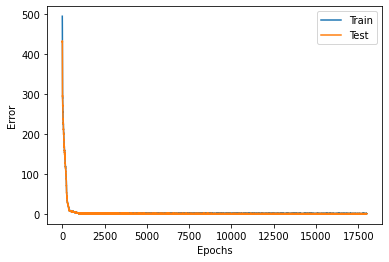

In [20]:
train_loss_list = torch.tensor(train_loss_list)
val_loss_list = torch.tensor(val_loss_list)

plt.plot(range(len(train_loss_list)), train_loss_list, label="Train")
plt.plot(range(len(val_loss_list)), val_loss_list, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

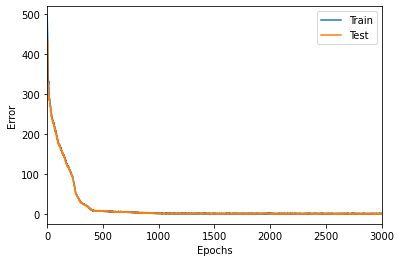

In [21]:
plt.xlim(0, 3000)
plt.plot(range(len(train_loss_list)), train_loss_list, label="Train")
plt.plot(range(len(val_loss_list)), val_loss_list, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [23]:
test_net = NET().to(device)
test_net.eval()
test_net.load_state_dict(torch.load('model' + str(best_epoch) + '.pth'))

<All keys matched successfully>

In [24]:
import seaborn
def test():
    test_net.eval()
    running_loss = 0
    with torch.no_grad():
        total_max_temp_error = 0
        total_min_temp_error = 0
        max_error_x = 0
        max_error_y = 0
        min_error_x = 0
        min_error_y = 0
        error_per_pix = 0
        loss_sum = 0
        max_error_x_abs = 0
        max_error_y_abs = 0
        min_error_x_abs = 0
        min_error_y_abs = 0
            
        estimate_list = []

        for batch_idx, (x, c) in enumerate(test_loader):
            estimate_start = time.time()
            print('=================================')
            x, c = tmp.next()
            x = x.to(device)
            c = c.to(device)
            y = model(x)
            estimate_end = time.time()
            estimate_duration = -estimate_start+estimate_end
            print("{}個目のモデルの推定時間は：{}秒です".format(batch_idx+1, estimate_duration))
            estimate_list.append(estimate_duration)
            continue
            loss = criterion(y, c)
            loss_unit = torch.sum(torch.abs(y-c))/16/18
            loss_sum = loss_sum + loss_unit
            running_loss += loss.item()
            
            
            y = y.cpu()
            c = c.cpu()
            c_reshaped = c.reshape(16, 18)
            seaborn.heatmap(c_reshaped, vmin=18, vmax=25)
            plt.show()
            y_reshaped = y.reshape(16, 18)
            seaborn.heatmap(y_reshaped, vmin=18, vmax=25)
            plt.show()
            
            #最高温度のずれ
            max_temp_output = torch.max(c)
            max_temp_target = torch.max(y)
            max_temp_error = max_temp_output - max_temp_target
            total_max_temp_error = total_max_temp_error + max_temp_error

            #最低温度のずれ
            min_temp_output = torch.min(c)
            min_temp_target = torch.min(y)
            min_temp_error = min_temp_output - min_temp_target
            total_min_temp_error = total_min_temp_error + min_temp_error

            #最高温度を示すピクセルの座標のずれ(絶対値)
            max_temp_arg = torch.argmax(c)
            max_x_output = (max_temp_arg + 1)%18 -1
            max_y_output = -(max_temp_arg + 1)//18

            max_temp_arg = torch.argmax(y)
            max_x_target = (max_temp_arg + 1)%18 -1
            max_y_target = -(max_temp_arg + 1)//18
            
            max_error_x = max_error_x + abs(max_x_output - max_x_target)
            max_error_y = max_error_y + abs(max_y_output - max_y_target)

            # 最低温度を示すピクセルの座標のずれ(絶対値)
            min_temp_arg = torch.argmin(c)
            min_x_output = (min_temp_arg + 1)%18 -1
            min_y_output = -(min_temp_arg + 1)//18

            min_temp_arg = torch.argmin(y)
            min_x_target = (min_temp_arg + 1)%18 -1
            min_y_target = -(min_temp_arg + 1)//18
            
            min_error_x = min_error_x + abs(min_x_output - min_x_target)
            min_error_y = min_error_y + abs(min_y_output - min_y_target)

    print("平均時間は{}秒です".format(sum(estimate_list)/len(estimate_list)))
    return 0

    print('1ピクセルあたりの誤差', loss_sum/len(test_loader))
    print('最高温度のずれ', total_max_temp_error/len(test_loader))      
    print('最低温度のずれ', total_min_temp_error/len(test_loader))
    print('最高温度を示すピクセルの座標のずれ', max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), )
    print('最低温度を示すピクセルの座標のずれ', min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), )
    
    print("batch_size: {}　です。頑張ってください".format(batchsize))
    print(fpath)
    p = [loss_sum/len(test_loader), total_max_temp_error/len(test_loader), total_min_temp_error/len(test_loader), max_error_x/len(test_loader), max_error_y/len(test_loader), min_error_x/len(test_loader), min_error_y/len(test_loader), max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), best_epoch]
    p = [float(x) for x in p]
    p.insert(0, "条件"+str(histwindow))
    print(*p, sep=', ')

    val_loss = running_loss / len(test_loader)

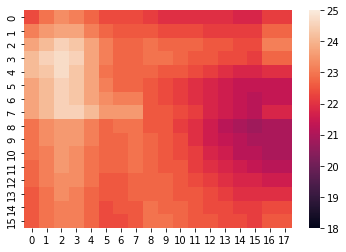

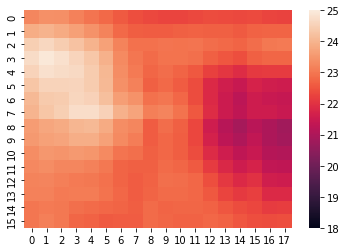

/tmp/ipykernel_585033/1668136297.py:64: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_x_output = (max_temp_arg + 1)//18
/tmp/ipykernel_585033/1668136297.py:68: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_x_target = (max_temp_arg + 1)//18
/tmp/ipykernel_585033/1668136297.py:79: UserWarning: __floordiv__ is deprecated, and its

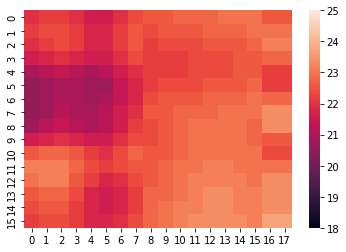

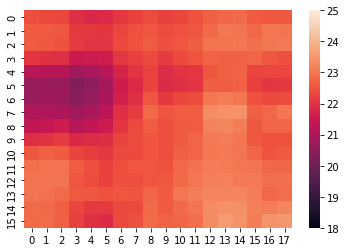

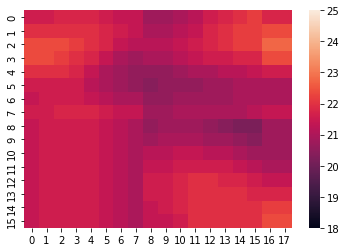

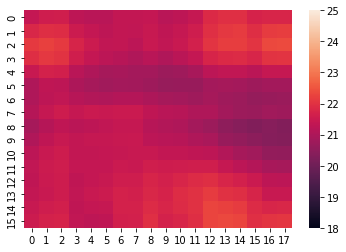

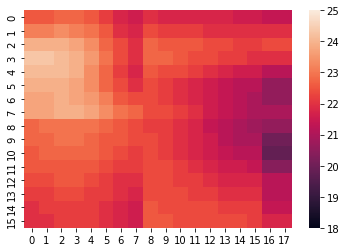

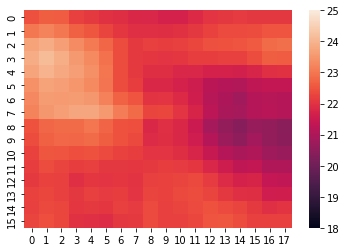

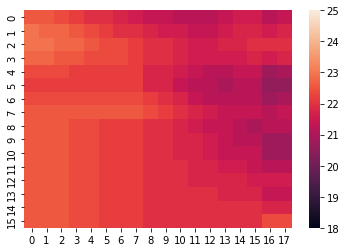

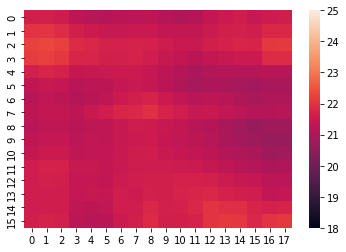

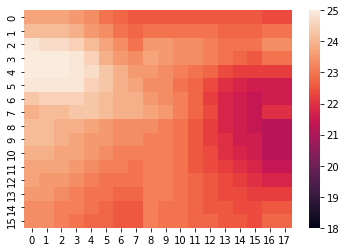

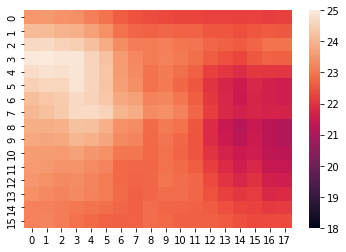

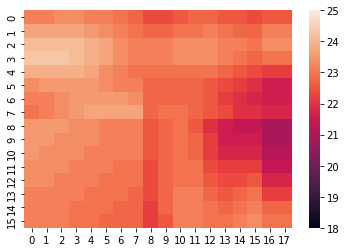

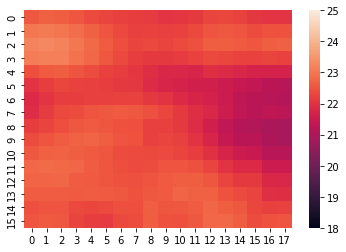

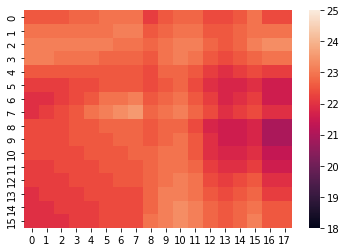

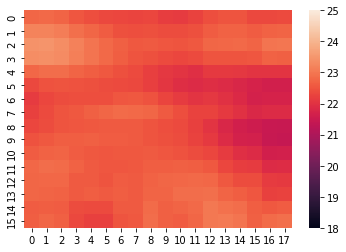

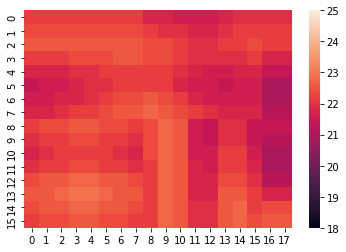

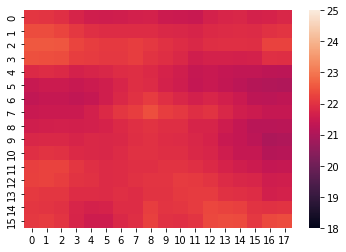

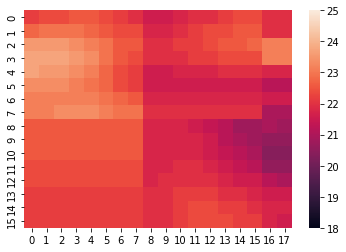

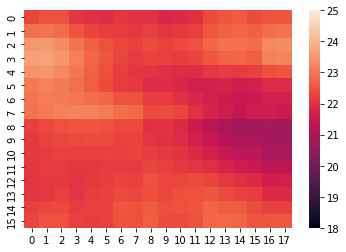

1ピクセルあたりの誤差その１ tensor(0.3209, device='cuda:0')
1ピクセルあたりの誤差 tensor(0.3879, device='cuda:0')
最高温度のずれ tensor(0.3015)
最低温度のずれ tensor(-0.1170)
最高温度を示すピクセルの座標のずれ tensor(1.5000) tensor(2.5000)
最低温度を示すピクセルの座標のずれ tensor(-1.1000) tensor(8.4000)
abs最高温度を示すピクセルの座標のずれ tensor(1.9000) tensor(3.5000)
abs最低温度を示すピクセルの座標のずれ tensor(1.9000) tensor(9.2000)
batch_size: 200　です。頑張ってください
/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50
条件1, 0.3209155201911926, 0.3014501631259918, -0.11704806983470917, 1.5, 2.5, -1.100000023841858, 8.399999618530273, 1.899999976158142, 3.5, 1.899999976158142, 9.199999809265137, 2998.0


In [25]:
test()

In [ ]:
print(min_temp_arg)
